In [1]:
%load_ext autoreload
%autoreload 2

# Mix of tabular + original image

In [2]:
from cape_core.tensordata import *
from cape_core.models import *
from cape_core.utils import L1Flat
from cape_core.ranger import *

In [3]:
PATH = Path.cwd()
IMAGEPATH = PATH/'zoom20_256/'

In [4]:
IMAGEPATH.ls()[0:5]

[PosixPath('/home/tc256760/Documents/Tabular_image_model/Sample Models/zoom20_256/cad4651444.jpg'),
 PosixPath('/home/tc256760/Documents/Tabular_image_model/Sample Models/zoom20_256/cad4432494.jpg'),
 PosixPath('/home/tc256760/Documents/Tabular_image_model/Sample Models/zoom20_256/cad5597246.jpg'),
 PosixPath('/home/tc256760/Documents/Tabular_image_model/Sample Models/zoom20_256/cad1776714.jpg'),
 PosixPath('/home/tc256760/Documents/Tabular_image_model/Sample Models/zoom20_256/cad5587051.jpg')]

# Model

In [5]:
columns = ['index', 'prop_aursrc', 'prop_modseg', 'asatMonth',
       'prop_lastpurchMonth', 'predval_rs', 'p_ab_rs_band', 'p_90_rs_band',
       'date_rsYear', 'dont_use_rs', 'predval_cs', 'p_ab_cs_band',
       'p_90_cs_band', 'dont_use_cs', 'predval_3party', 'p_ab_3party_band',
       'p_90_3party_band', 'date_3partyYear', 'dont_use_3party', 'prop_munval',
       'prop_munvalYear', 'prop_aur', 'prop_bedrooms', 'prop_bathrooms',
       'prop_age', 'slope', 'cad_sqm', 'estateschemedensity', 'asatYear',
       'asatElapsed', 'prop_lastpurchpriceinfl', 'prop_lastpurchYear', 'x',
       'y', 'munic_id', 'distancemtoairportint',
       'distancemtolargeretailcentre', 'distancemtomediumretailcentre',
       'cad_metersfromwater', 'cad_metersfromcoast', 'pct_offprops_cdn',
       'prop_minlistingprice', 'prop_firstlistingElapsedMonthsToDate',
       'area_avglistingvaluerecent', 'area_minlistingrecent',
       'area_maxlistingrecent', 'prop_recentotp',
       'prop_recentotpElapsedMonthsToDate', 'area_avgotprecent',
       'area_volotprecent', 'predval_final_3party', 'p_ab_final_3party_band',
       'p_90_final_3party_band', 'cad_id', 'prop_id', 'asatdate',
       'prop_titledeedtype', 'estate_id', 'sgr_id', 'suburb_id',
       'trf_purchprice', 'prop_munvalinfl']

In [6]:
df_train = pd.read_pickle(PATH/'df_train_sample.pkl').drop('index', 1)
df_valid = pd.read_pickle(PATH/'df_valid_sample.pkl').drop('index', 1)
data = pd.concat([df_train, df_valid])

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100000 entries, 23072 to 142050
Data columns (total 61 columns):
p_ab_rs_band                            100000 non-null int32
p_90_rs_band                            100000 non-null int32
dont_use_rs                             100000 non-null int32
p_ab_cs_band                            100000 non-null int32
p_90_cs_band                            100000 non-null int32
dont_use_cs                             100000 non-null int32
p_ab_3party_band                        100000 non-null int32
p_90_3party_band                        100000 non-null int32
dont_use_3party                         100000 non-null int32
prop_aursrc                             100000 non-null int64
prop_bedrooms                           100000 non-null int32
prop_modseg                             100000 non-null int64
asatMonth                               100000 non-null int64
prop_lastpurchMonth                     100000 non-null int64
p_ab_final_3party

In [8]:
data.shape

(100000, 61)

In [9]:
data.columns

Index(['p_ab_rs_band', 'p_90_rs_band', 'dont_use_rs', 'p_ab_cs_band',
       'p_90_cs_band', 'dont_use_cs', 'p_ab_3party_band', 'p_90_3party_band',
       'dont_use_3party', 'prop_aursrc', 'prop_bedrooms', 'prop_modseg',
       'asatMonth', 'prop_lastpurchMonth', 'p_ab_final_3party_band',
       'p_90_final_3party_band', 'predval_rs', 'date_rsYear', 'predval_cs',
       'predval_3party', 'date_3partyYear', 'prop_munval', 'prop_munvalYear',
       'prop_aur', 'prop_bathrooms', 'prop_age', 'slope', 'cad_sqm',
       'estateschemedensity', 'asatYear', 'asatElapsed',
       'prop_lastpurchpriceinfl', 'prop_lastpurchYear', 'x', 'y', 'munic_id',
       'distancemtoairportint', 'distancemtolargeretailcentre',
       'distancemtomediumretailcentre', 'cad_metersfromwater',
       'cad_metersfromcoast', 'pct_offprops_cdn', 'prop_minlistingprice',
       'prop_firstlistingElapsedMonthsToDate', 'area_avglistingvaluerecent',
       'area_minlistingrecent', 'area_maxlistingrecent', 'prop_recentotp',

In [16]:
def verify_against_files(image_list, image_path):
    image_set =set([f.name for f in image_path.ls()])
    inter = set(image_list).intersection(image_set)
    print(f'Image List {len(image_list)}, available images: {len(inter)}')
    return list(inter)

# available_images = pd.DataFrame(verify_against_files(labels.fname, IMAGEPATH),columns=['fname'])
available_images = pd.DataFrame([f.name for f in get_image_files(IMAGEPATH)],columns=['fname'])
available_labels = available_images.assign(cad_id = lambda x: x.fname.str[3:-4]).astype(dtype={'fname':str, 'cad_id':int})

In [103]:
N = len(df_train)

In [17]:
available_labels.head()

,fname,cad_id
0,cad4651444.jpg,4651444
1,cad4432494.jpg,4432494
2,cad5597246.jpg,5597246
3,cad1776714.jpg,1776714
4,cad5587051.jpg,5587051


In [18]:
data = pd.merge(data, available_labels, on='cad_id')
data.shape

(99984, 62)

In [19]:
data.head()

,p_ab_rs_band,p_90_rs_band,dont_use_rs,p_ab_cs_band,p_90_cs_band,dont_use_cs,p_ab_3party_band,p_90_3party_band,dont_use_3party,prop_aursrc,...,cad_id,prop_id,asatdate,prop_titledeedtype,estate_id,sgr_id,suburb_id,trf_purchprice,prop_munvalinfl,fname
0,8,10,0,4,7,0,0,0,1,9,...,6905651,11944540,2017-04-15,FH,0.0,0,9834.0,1550000.0,0.0,cad6905651.jpg
1,8,9,0,6,8,0,0,0,1,7,...,4669236,11360646,2017-09-11,FH,0.0,0,3496.0,900000.0,0.0,cad4669236.jpg
2,8,8,0,7,10,0,0,0,1,17,...,1057686,11435648,2017-02-08,FH,0.0,0,48.0,1995000.0,0.0,cad1057686.jpg
3,9,10,0,7,8,0,0,0,1,17,...,5487873,15736748,2017-11-07,FH,0.0,0,5545.0,900000.0,0.0,cad5487873.jpg
4,8,8,0,6,8,0,0,0,1,7,...,168364,9485339,2017-10-17,FH,0.0,0,4339.0,1230000.0,939320.0,cad168364.jpg


In [20]:
N = len(df_train)

In [21]:
cat_names = ['prop_aursrc','prop_modseg','asatMonth','prop_lastpurchMonth',
             'estate_id','prop_munvalYear','prop_lastpurchYear','dont_use_rs','asatElapsed','p_90_cs_band',
            'prop_bedrooms','date_3partyYear','asatYear','p_ab_final_3party_band','p_90_rs_band','p_90_3party_band',
             'p_ab_rs_band','date_rsYear','p_90_final_3party_band','dont_use_cs','prop_bathrooms','dont_use_3party',
            'p_ab_cs_band','p_ab_3party_band','munic_id','suburb_id']
cont_names = ['pct_offprops_cdn',
             'prop_munvalinfl',
             'prop_munval',
             'prop_lastpurchpriceinfl',
             'prop_firstlistingElapsedMonthsToDate',
             'prop_minlistingprice',
             'area_volotprecent',
             'distancemtoairportint',
             'predval_cs',
             'x',
             'predval_3party',
             'prop_recentotp',
             'estateschemedensity',
             'prop_aur',
             'area_maxlistingrecent',
             'cad_metersfromwater',
             'area_minlistingrecent',            
             'area_avglistingvaluerecent',
             'prop_age',
             'predval_final_3party',
             'distancemtolargeretailcentre',
             'area_avgotprecent',
             'y',        
             'predval_rs',
             'cad_metersfromcoast',
             'prop_recentotpElapsedMonthsToDate',
             'slope',   
             'cad_sqm',
             'distancemtomediumretailcentre']

In [22]:
dep_var='trf_purchprice'
procs = [FillMissing, Categorify, Normalize]
max_log_y = np.log(np.max(data[dep_var])*1.2)
y_range = torch.tensor([12, max_log_y], device=defaults.device); y_range

tensor([12.0000, 15.6073], device='cuda:0')

In [23]:
image_il = ImageList.from_df(data[['fname']], IMAGEPATH, cols='fname')
tabular_il = TabularList.from_df(data[cat_names+cont_names+[dep_var]], cat_names, cont_names, procs)

In [24]:
tfms = get_transforms(flip_vert=True, max_lighting=0.1, max_zoom=1.05, max_warp=0.)

In [25]:
db = (MixedItemList([tabular_il, image_il], path=PATH, inner_df=tabular_il.inner_df)
      .split_by_idx(range(N, len(data)))
      .label_from_df(cols=dep_var, log=True)
      .transform([[[], tfms[0]], [[], tfms[1]]])
      .databunch(no_check=True, bs=128)
     )

In [26]:
x, y = db.one_batch()

cat, cont, image

In [27]:
x[0][0].shape, x[0][1].shape, x[1].shape

(torch.Size([128, 26]), torch.Size([128, 29]), torch.Size([128, 3, 256, 256]))

In [28]:
learn = tabular_image_learner(db, 
                              img_arch=models.xresnet34,
                              layers=[512,512,256],  
                              y_range=y_range, 
                              emb_drop=0.1,
                              loss_func=L1Flat(),
                              opt_func=Ranger,
                              metrics=exp_rmspe).to_fp16(clip=1)

cut=8, pool=<class 'torch.nn.modules.pooling.AdaptiveAvgPool2d'>


In [29]:
learn.model

TabularImageModel(
  (embeds): ModuleList(
    (0): Embedding(18, 8)
    (1): Embedding(17, 8)
    (2): Embedding(13, 7)
    (3): Embedding(13, 7)
    (4): Embedding(4155, 170)
    (5): Embedding(14, 7)
    (6): Embedding(53, 15)
    (7): Embedding(3, 3)
    (8): Embedding(28, 10)
    (9): Embedding(12, 6)
    (10): Embedding(7, 5)
    (11): Embedding(49, 14)
    (12): Embedding(4, 3)
    (13): Embedding(12, 6)
    (14): Embedding(12, 6)
    (15): Embedding(12, 6)
    (16): Embedding(12, 6)
    (17): Embedding(40, 13)
    (18): Embedding(12, 6)
    (19): Embedding(3, 3)
    (20): Embedding(12, 6)
    (21): Embedding(3, 3)
    (22): Embedding(12, 6)
    (23): Embedding(12, 6)
    (24): Embedding(193, 30)
    (25): Embedding(4963, 188)
  )
  (emb_drop): Dropout(p=0.1)
  (bn_cont): BatchNorm1d(29, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layers): Sequential(
    (0): Linear(in_features=1089, out_features=512, bias=True)
    (1): ReLU(inplace)
    (2): BatchNorm1d

# Train

set state called
LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


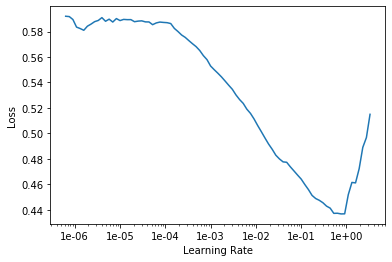

In [30]:
learn.lr_find(); learn.recorder.plot()

In [31]:
learn.fit_fc(6, 1e-3)

epoch,train_loss,valid_loss,exp_rmspe,time
0,0.204169,0.189894,0.330268,04:15
1,0.180945,0.175073,0.311792,04:14
2,0.173943,0.205423,0.332394,04:15
3,0.165884,0.172895,0.314913,04:58


Traceback (most recent call last):
  File "/home/tc256760/anaconda3/envs/fastai/lib/python3.7/multiprocessing/queues.py", line 242, in _feed
    send_bytes(obj)
  File "/home/tc256760/anaconda3/envs/fastai/lib/python3.7/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/home/tc256760/anaconda3/envs/fastai/lib/python3.7/multiprocessing/connection.py", line 404, in _send_bytes
    self._send(header + buf)
  File "/home/tc256760/anaconda3/envs/fastai/lib/python3.7/multiprocessing/connection.py", line 368, in _send
    n = write(self._handle, buf)
BrokenPipeError: [Errno 32] Broken pipe
Traceback (most recent call last):
  File "/home/tc256760/anaconda3/envs/fastai/lib/python3.7/multiprocessing/queues.py", line 242, in _feed
    send_bytes(obj)
  File "/home/tc256760/anaconda3/envs/fastai/lib/python3.7/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/home/tc256760/anaco

KeyboardInterrupt: 

In [22]:
learn.save('tab_img_v4', return_path=True)

PosixPath('/home/tc256760/Documents/Tabular_image_model/models/tab_img_v3.pth')